In [94]:

#imports

import numpy as np
import Sparse_Subpixel_Convolution as SpConv

from PIL import Image
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle

from ipywidgets import Layout, interact, IntSlider, FloatSlider
import time
import gc


#Consts
nanometers_per_pixel = 46

dt = 0.1
# t_max = 6.4
t_max = 102.4

psf_peak_pixel_size = 32

camera_fov_px = 64

steps = int(t_max / dt)

exD = 5000.0
exParticle_count = 500
# exParticle_count = 1



In [2]:
#Load PSF
PSF_subpx = np.load("../PSF_subpx_fl32.npy")
sample_size_px = PSF_subpx.shape[2] - camera_fov_px
print("Sample width: ", sample_size_px)

Sample width:  448


In [95]:

FOV_edge = sample_size_px / 2 - camera_fov_px / 2

sample_count = 1000
sample_count = 1

    
def GenParticlePositions(D : float, particle_count : int, step_count : int, loop : bool):
    variance = 4 * D * dt / (nanometers_per_pixel ** 2)

    start_poss = np.random.uniform(0, sample_size_px, (particle_count, 2))
    dposs = np.random.normal(0, variance, (step_count, particle_count, 2))

    poss = start_poss[None, :, :] + np.cumsum(dposs, axis = 0)
    
    s = sample_size_px
    
    if(loop):
        poss[poss < 0] = poss[poss < 0] + np.floor(-poss[poss < 0] / s + 1) * s
        poss[poss > s] = poss[poss > s] - np.floor( poss[poss > s] / s + 0) * s
    
    poss -= FOV_edge
    
    return poss #shape: (steps, particle_count, coordinates)

sz = camera_fov_px
subpixels = PSF_subpx.shape[0]

import multiprocessing
number_of_threads = multiprocessing.cpu_count()
print(number_of_threads)


optimized_thread_cnt = 1
conv_calc = SpConv.ConvolutionCalculator_fl32(PSF_subpx, optimized_thread_cnt, verbose=1)

12


In [100]:
particle_count = exParticle_count * sample_count

poss = GenParticlePositions(exD, particle_count, steps, True)


last_mean_x = poss[:, -1, 0].mean()
last_mean_y = poss[:, -1, 1].mean()

##Put the last pt in center
# poss[:, -1, 0] -= last_mean_x - 32
# poss[:, -1, 1] -= last_mean_y - 32

# print(last_mean_x, last_mean_y)
# print(poss[:, -1, :])

##Remove NPs in FOV
# xc_in_sight = (poss[:, :, 0] > 0) & (poss[:, :, 0] < camera_fov_px)
# yc_in_sight = (poss[:, :, 1] > 0) & (poss[:, :, 1] < camera_fov_px)
# pt_in_sight = xc_in_sight & yc_in_sight
# pt_in_sight_inds = np.nonzero(pt_in_sight)
# poss[:, pt_in_sight_inds[1], :] = -100000


sample_sizes = np.full((sample_count), exParticle_count, dtype=np.int32)

thread_count = int(number_of_threads * 2 / 3)

intensities = np.full((particle_count), 1, dtype=np.float32)
# intensities[-1] = 4.0 ##

samples = conv_calc.convolve(thread_count, camera_fov_px, poss, sample_sizes, intensities, verbose=1)

In [101]:

#Draw Fast & Generate targets
sample_inds = np.insert(np.cumsum(sample_sizes), 0, 0)

xc_in_sight = (poss[:, :, 0] > 0) & (poss[:, :, 0] < camera_fov_px)
yc_in_sight = (poss[:, :, 1] > 0) & (poss[:, :, 1] < camera_fov_px)
pt_in_sight = xc_in_sight & yc_in_sight

particles_in_sight_cnt = list()
for i in range(sample_count):
    particles_in_sight_cnt.append(np.sum(pt_in_sight[:, sample_inds[i]:sample_inds[i+1]], axis = 1))

precision_multiplier = 4
targets = np.zeros((steps, sample_count, camera_fov_px * precision_multiplier, camera_fov_px * precision_multiplier), dtype=np.uint8)

for i in range(sample_count):
    for step in range(steps):
        sample_pt = np.nonzero(pt_in_sight[step, sample_inds[i]:sample_inds[i+1]])
        sample_ps = poss[step, sample_inds[i]:sample_inds[i+1], :]
        positions_in_sight = (sample_ps[sample_pt, :] * precision_multiplier).astype(int)[0]
        targets[step, i, positions_in_sight[:, 0], positions_in_sight[:, 1]] = 1
    
    


def plot_step_fast_wTargets(step, sample_cur):
    
    begin = sample_inds[sample_cur]
    end = begin + sample_sizes[sample_cur]
    
    x = poss[step, begin:end, 1]
    y = poss[step, begin:end, 0]
    
    plt.subplot(1, 2, 1)
    plt.axis([-FOV_edge, sample_size_px-FOV_edge, -FOV_edge, sample_size_px-FOV_edge])
    plt.gca().add_patch(Rectangle((0, 0), camera_fov_px, camera_fov_px, edgecolor = 'red', fill=False))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.scatter(x,y)
    
    imgs = samples[sample_cur]
    plt.subplot(1, 2, 2)
    plt.imshow(imgs[step, :, :])
    plt.axis([-0.5, camera_fov_px-0.5, -0.5, camera_fov_px-0.5])
#     plt.scatter(x,y, c="red")
    plt.scatter(x[-1:],y[-1:], c="red")
    plt.scatter(x[:-1],y[:-1], c="blue")
    print(x[-1:],y[-1:])
    plt.show()
    
    plt.imshow(targets[step, sample_cur, :, :])
    plt.axis([-0.5, camera_fov_px * precision_multiplier-0.5, -0.5, camera_fov_px * precision_multiplier-0.5])
    plt.show()
    print(particles_in_sight_cnt[sample_cur][step])
    


    
interact(plot_step_fast_wTargets, step=IntSlider(min=0, max=steps - 1, layout=Layout(width='100%')), sample_cur=IntSlider(min=0, max=sample_count - 1, layout=Layout(width='100%')));


interactive(children=(IntSlider(value=0, description='step', layout=Layout(width='100%'), max=1023), IntSlider…

In [102]:
particles_per_sample = np.sum(particles_in_sight_cnt, axis = 1)

print(particles_per_sample.min(), np.argmin(particles_per_sample))
print(particles_per_sample.max(), np.argmax(particles_per_sample))



10929 0
10929 0


(500, 2)


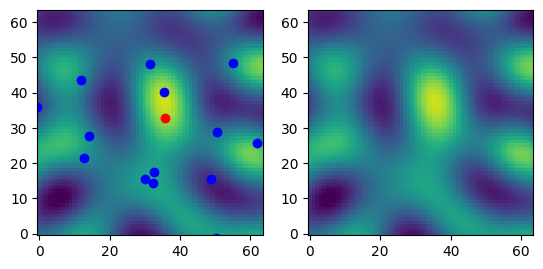

In [67]:
#Last particle highlighted
import matplotlib.animation as animation

sample_cur = 0
sample_inds = np.insert(np.cumsum(sample_sizes), 0, 0)
step = 0

fig = plt.figure()
imgs = samples[sample_cur]
    
plt.subplot(1, 2, 1)
im1 = plt.imshow(imgs[step, :, :], animated=True)
plt.axis([-0.5, camera_fov_px-0.5, -0.5, camera_fov_px-0.5])
    

begin = sample_inds[sample_cur]
end = begin + sample_sizes[sample_cur]

x = poss[step, begin:end, 1]
y = poss[step, begin:end, 0]
scat1 = plt.scatter(x[-1:],y[-1:], c="red")
scat2 = plt.scatter(x[:-1],y[:-1], c="blue")

plt.subplot(1, 2, 2)
im2 = plt.imshow(imgs[step, :, :], animated=True)
plt.axis([-0.5, camera_fov_px-0.5, -0.5, camera_fov_px-0.5])

print(np.array([x, y]).T.shape)

def updatefig(args):
    global step
    step += 1
    step %= steps
    im1.set_array(imgs[step, :, :])
    im2.set_array(imgs[step, :, :])
    
    
    begin = sample_inds[sample_cur]
    end = begin + sample_sizes[sample_cur]

    x = poss[step, begin:end, 1]
    y = poss[step, begin:end, 0]
    scat1.set_offsets(np.array([x[-1:],y[-1:]]).T)
    scat2.set_offsets(np.array([x[:-1],y[:-1]]).T)
    return im1, scat1, scat2, im2

anim = animation.FuncAnimation(fig, updatefig, interval=100, blit=True, repeat = True, frames = steps)
anim.save('visualizations/moreintenseNP.mp4', writer = 'ffmpeg', fps = 30)

(500, 2)


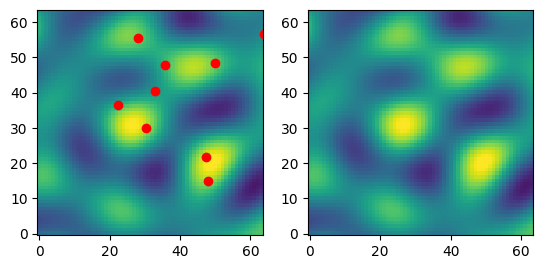

In [103]:

import matplotlib.animation as animation

sample_cur = 0
sample_inds = np.insert(np.cumsum(sample_sizes), 0, 0)
step = 0

fig = plt.figure()
imgs = samples[sample_cur]
    
plt.subplot(1, 2, 1)
im1 = plt.imshow(imgs[step, :, :], animated=True)
plt.axis([-0.5, camera_fov_px-0.5, -0.5, camera_fov_px-0.5])
    

begin = sample_inds[sample_cur]
end = begin + sample_sizes[sample_cur]

x = poss[step, begin:end, 1]
y = poss[step, begin:end, 0]
scat = plt.scatter(x,y, c="red")

plt.subplot(1, 2, 2)
im2 = plt.imshow(imgs[step, :, :], animated=True)
plt.axis([-0.5, camera_fov_px-0.5, -0.5, camera_fov_px-0.5])

print(np.array([x, y]).T.shape)

def updatefig(args):
    global step
    step += 1
    step %= steps
    im1.set_array(imgs[step, :, :])
    im2.set_array(imgs[step, :, :])
    
    
    begin = sample_inds[sample_cur]
    end = begin + sample_sizes[sample_cur]

    x = poss[step, begin:end, 1]
    y = poss[step, begin:end, 0]
    scat.set_offsets(np.array([x, y]).T)
    return im1, scat, im2

anim = animation.FuncAnimation(fig, updatefig, interval=100, blit=True, repeat = True, frames = steps)
anim.save('visualizations/NPs_in_sight.mp4', writer = 'ffmpeg', fps = 30)

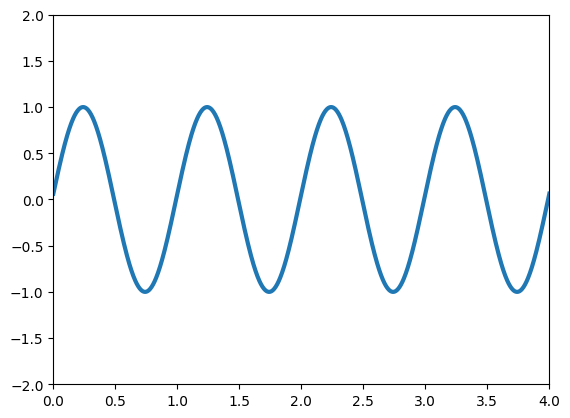

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation 
   
# initializing a figure in 
# which the graph will be plotted
fig = plt.figure() 
   
# marking the x-axis and y-axis
axis = plt.axes(xlim =(0, 4), 
                ylim =(-2, 2)) 
  
# initializing a line variable
line, = axis.plot([], [], lw = 3) 
   
# data which the line will 
# contain (x, y)
def init(): 
    line.set_data([], [])
    return line,
   
def animate(i):
    x = np.linspace(0, 4, 1000)
   
    # plots a sine graph
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
      
    return line,
   
anim = FuncAnimation(fig, animate, init_func = init,
                     frames = 200, interval = 20, blit = True)
  
anim.save('growingCoil.mp4', writer = 'ffmpeg', fps = 30)